In [3]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph

  Using cached langchain_community-0.0.36-py3-none-any.whl (2.0 MB)
  Using cached tiktoken-0.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached langchain_openai-0.1.6-py3-none-any.whl (34 kB)
  Using cached langchainhub-0.1.15-py3-none-any.whl (4.6 kB)
  Using cached chromadb-0.5.0-py3-none-any.whl (526 kB)
  Using cached langchain-0.1.17-py3-none-any.whl (867 kB)
  Using cached langgraph-0.0.44-py3-none-any.whl (67 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.9/312.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool
from langchain.docstore.document import Document
import os

import openai as OpenAI
from google.colab import userdata

#LangGraph Retrieval Agent

##Retriever

In [5]:
def read_text_files(directory_path):
    texts = {}
    # List all files in the given directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.txt'):  # Check if the file is a text file
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                texts[filename] = file.read()
    return texts

In [6]:
Openai_API_key=userdata.get('Openai_API_key')

In [7]:
# Read data
file_path = '/content/drive/MyDrive/vector_embedding'  # Replace with your actual text file path
text = read_text_files(file_path)

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=50
)

doc_splits = []

for filename, content in text.items():

    tokenized_texts = text_splitter.split_text(content)  # Tokenize the content of each file
    for chunk in tokenized_texts:
        doc_splits.append(Document(page_content=chunk, metadata={'source_document':filename}))

print(f"Number of chunks: {len(doc_splits)}")
print(f"Source document of 2nd chunk: {doc_splits[1].metadata['source_document']}")

# doc_splits = text_splitter.split_documents(text)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(openai_api_key=Openai_API_key),
)
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 2})


Number of chunks: 7
Source document of 2nd chunk: diagnosis.txt


## Retreival Tool

In [8]:
from langchain.tools.retriever import create_retriever_tool

tool = create_retriever_tool(
    retriever,
    "retrieve_text",
    "Search and return relevant information from documents about the user's questions to generate the accurate answers.",
)

tools = [tool]

from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

###Agent state
#####We will defined a graph. A state object that it passes around to each node. Our state will be a list of messages. Each node in our graph will append to it.

In [9]:
### Retrieval Grader

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Updated data model with explanation
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents with explanation."""
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")
    explanation: str = Field(description="Explanation of why the document is or is not relevant to the question")

# Initialize the LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0, api_key=Openai_API_key)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Updated system prompt to include reasoning
system = """You are a grader tasked with evaluating the relevance of a retrieved document segment in response to a user's question. Determine whether this segment is the most pertinent excerpt from the document, effectively and precisely addressing the user's query.
Grade the document as relevant ('yes') or not relevant ('no') and explain your detiled logical reasoning based on the presence of keyword(s) or semantic meanings related to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n{Retrieved_document} \n\n User question: {question} \n\n User document: {document}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

# Assuming all_document_content contains the content of the retrieved document and docs is the full document
# doc_txt = all_document_content
# response = retrieval_grader.invoke({"question": query_question, "Retrieved_document": doc_txt, "document": doc_splits})

# print(f"Relevance: {response.binary_score}")
# print(f"Explanation: {response.explanation}")

# # Example usage
# # save_to_docx( question= query_question, retrieved_document= doc_txt, relevance= response.binary_score, explanation= response.explanation)


In [10]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser


# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, api_key=Openai_API_key)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

In [11]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0, api_key=Openai_API_key)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for web search. Look at the input and try to reason about the underlying sematic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question."),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
# question_rewriter.invoke({"question": question})

In [13]:
class EvaluateAnswers(BaseModel):
    best_answer: str = Field(description="Which answer is more correct, or specify if both are equally valid or invalid.")
    explanation: str = Field(description="Detailed explanation of why one answer is better, both are acceptable, or both are inadequate.")

# Initialize the language model with structured output
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0, api_key=Openai_API_key)
structured_llm_evaluator = llm.with_structured_output(EvaluateAnswers)

# System prompt to evaluate and compare answers
system = """
Assess the accuracy and relevancy of the two provided answers in relation to the given question. Use the context to determine:
- If each answer directly addresses the question's topic.
- If the answer is factually correct and relevant based on the context.

Note:
- Clearly state if neither answer addresses the question correctly or is factually incorrect.
- Specify which answer, if any, is more relevant and why, even if neither is fully correct.
"""
evaluate_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Context: {context} \n\n Question: {question} \n\n Answer 1: {answer1} \n\n Answer 2: {answer2}"),
    ]
)


# Combine prompt template with structured output
answer_evaluator = evaluate_prompt | structured_llm_evaluator

In [12]:
from typing_extensions import TypedDict
from typing import List
from langgraph.graph import END, StateGraph

class GraphState(TypedDict):
    """|
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of retrieved documents
        all_documents: full context
        re_generate: rewrite the query question
    """
    question : str
    generation : str
    documents : List[str]
    all_documents: List[str]
    re_generate: str

In [17]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    print(f"State message: {state}")

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]


    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    all_docs = state["all_documents"]
    print(f"State:{state}")
    # Score each doc
    filtered_docs = []
    re_gen = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "Retrieved_document": d.page_content, "document": all_docs})
        grade = score.binary_score
        if grade == "yes":
            print("---The documents are relevant to the user's question---")
            print(f"Explanation: {score.explanation}")
            filtered_docs.append(d)
        else:
            print("---The documents are not relevant to the user's question---")
            print(f"Explanation: {score.explanation}")
            re_gen = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "re_generate":re_gen, "Assessment":score}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


### Edges

def decide_to_retrieve(state):
    """
    Determines whether to retreive the documents again based on transformed query.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---Checking the relevance of query: ---")
    question = state["question"]
    re_gen = state["re_generate"]
    filtered_documents = state["documents"]

    if "transform_query":
      print("---DECISION: Retrieving documents again based on tranformed query---")
      return "retrieve"

    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---Checking the relevance of query: ---")
    question = state["question"]
    filtered_documents = state["documents"]
    re_gen = state["re_generate"]

    if re_gen == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    second_ans= "This is a hypothetical answer"

    score = answer_evaluator.invoke({"context": documents, "question":question ,"answer1": generation, "answer2": second_ans })
    relevance = score.best_answer

      # Determine which answer is more accurate or if neither is correct
    if relevance == 'Answer 1':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS AND ANSWER 1 IS MORE RELEVANT---")
        print(f"Explanation: {score.explanation}")
        return "useful"
    elif relevance == 'Answer 2':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS AND ANSWER 2 IS MORE RELEVANT---")
        print(f"Explanation: {score.explanation}")
        return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


In [18]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query


# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

workflow.add_edge("generate", END)

workflow.add_conditional_edges(
    "transform_query",
    decide_to_retrieve,
    {
        "retrieve":"retrieve",
        "generate": "generate",
    },
)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": END,
        "useful": END,
        "not useful": "generate",
    },
)

# workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [102]:
answer = app.invoke(inputs)

---RETRIEVE---
State message: {'question': 'What were the key discoveries made in the 1980s that advanced our understanding of the causes of Duchenne Muscular Dystrophy (DMD)?', 'generation': None, 'documents': None, 'all_documents': None, 're_generate': None}
---CHECK DOCUMENT RELEVANCE TO QUESTION---
State:{'question': 'What were the key discoveries made in the 1980s that advanced our understanding of the causes of Duchenne Muscular Dystrophy (DMD)?', 'generation': None, 'documents': [Document(page_content="Duchenne Muscular Dystrophy Causes/Inheritance\n\nCause of DMD\nUntil the 1980s, little was known about the cause of any of the forms of muscular dystrophy. In 1986, MDA-supported researchers identified a gene on the X chromosome that, when flawed (mutated), causes Duchenne, Becker, and an intermediate form of muscular dystrophies.\nGenes contain codes, or recipes, for proteins, which are important biological components in all forms of life. In 1987, the protein associated with th

In [19]:
from pprint import pprint

# Run
inputs = {"question": "What were the key discoveries made in the 1980s that advanced our understanding of the causes of Duchenne Muscular Dystrophy (DMD)?"}
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

---RETRIEVE---
State message: {'question': 'What were the key discoveries made in the 1980s that advanced our understanding of the causes of Duchenne Muscular Dystrophy (DMD)?', 'generation': None, 'documents': None, 'all_documents': None, 're_generate': None}
Output from node 'retrieve':
---
{'question': 'What were the key discoveries made in the 1980s that advanced our understanding of the causes of Duchenne Muscular Dystrophy (DMD)?', 'documents': [Document(page_content="Duchenne Muscular Dystrophy Causes/Inheritance\n\nCause of DMD\nUntil the 1980s, little was known about the cause of any of the forms of muscular dystrophy. In 1986, MDA-supported researchers identified a gene on the X chromosome that, when flawed (mutated), causes Duchenne, Becker, and an intermediate form of muscular dystrophies.\nGenes contain codes, or recipes, for proteins, which are important biological components in all forms of life. In 1987, the protein associated with the DMD gene was identified and named 

In [22]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 2.24.33-2ubuntu2 [15.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64

In [25]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass


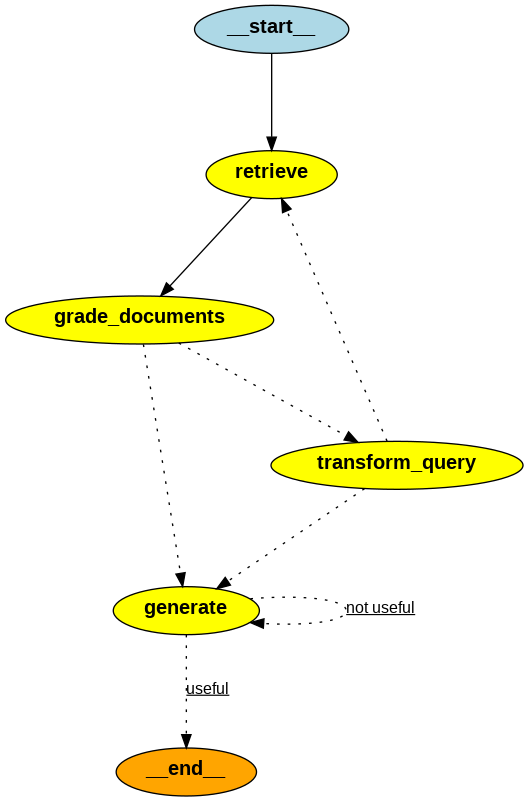

In [24]:
from IPython.display import display, HTML
import base64


def display_image(image_bytes: bytes, width=300):
    decoded_img_bytes = base64.b64encode(image_bytes).decode("utf-8")
    html = f'<img src="data:image/png;base64,{decoded_img_bytes}" style="width: {width}px;" />'
    display(HTML(html))

display_image(app.get_graph().draw_png())